# Model 3 Fine Tuning
- Transfer learning with ConvNeXtTiny

In [1]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
import tensorflow_hub as hub
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Load the processed dataset from Model3_TL

In [3]:
# load numpy array from npy file
from numpy import load

X_train_std = load("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/X_train_std3.npy")
X_test_std = load("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/X_test_std3.npy")

y_train = load("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/y_train3.npy")
y_test = load("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/y_test3.npy")

In [4]:
print("X_train_std_shape: {}".format(X_train_std.shape))
print("X_test_std_shape: {}".format(X_test_std.shape))

X_train_std_shape: (809, 299, 299, 3)
X_test_std_shape: (270, 299, 299, 3)


## Load the model from Model3_TL
- We apply fine tuning on this model

In [6]:
# Load the saved best model
from keras import layers

class LayerScale(layers.Layer):
    """Layer scale module.

    References:
      - https://arxiv.org/abs/2103.17239

    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.

    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

model3_FT = keras.models.load_model("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/Model3_TL.h5", custom_objects={"LayerScale": LayerScale} )
model3_FT.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 convnext_tiny_prestem_norm  (None, None, None, 3)        0         ['input_2[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_tiny_stem (Sequen  (None, None, None, 96)       4896      ['convnext_tiny_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                            

## Set all layers as trainable

In [8]:
total_layers = len(model3_FT.layers)
freeze_layer = round(total_layers * 0.30)

for layer in model3_FT.layers[:freeze_layer]:
  layer.trainable = False

for layer in model3_FT.layers[freeze_layer:]:
  layer.trainable = True



## Compile, fit and evaluate the model
- Save the best weights while training

In [9]:
model3_FT.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

callbacks3_FT = [
             keras.callbacks.ModelCheckpoint("bestFT3.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)
]

history3_FT = model3_FT.fit(x = X_train_std, y = y_train, epochs=10,
                                      validation_split=0.1, batch_size=16, callbacks=callbacks3_FT)

Epoch 1/10
46/46 [==============================] - 65s 635ms/step - loss: 0.1938 - accuracy: 0.9368 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 2/10
46/46 [==============================] - 18s 398ms/step - loss: 3.5460e-04 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 0.9877
Epoch 3/10
46/46 [==============================] - 19s 409ms/step - loss: 5.1281e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9877
Epoch 4/10
46/46 [==============================] - 19s 410ms/step - loss: 3.5089e-05 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9877
Epoch 5/10
46/46 [==============================] - 19s 417ms/step - loss: 2.4327e-05 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9877
Epoch 6/10
46/46 [==============================] - 20s 429ms/step - loss: 2.1125e-05 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9877
Epoch 7/10
46/46 [==============================] - 20s 429ms/step - loss: 1.5282e-05 - accuracy: 1.0000 - val_loss: 0.018

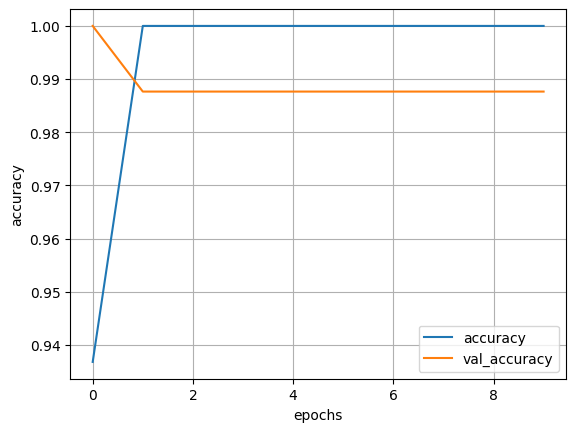

In [10]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history3_FT.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

In [11]:
testLoss_FT, testAccuracy_FT = model3_FT.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FT, testAccuracy_FT))

9/9 [==============================] - 10s 734ms/step - loss: 9.0725e-06 - accuracy: 1.0000
Test-loss: 0.000009, Test-accuracy: 1.000000


In [12]:
# Plugging best weights to the model to evaluate

model3_FT.load_weights("bestFT3.h5")

testLoss_FT, testAccuracy_FT = model3_FT.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FT, testAccuracy_FT))

9/9 [==============================] - 3s 378ms/step - loss: 0.0047 - accuracy: 1.0000
Test-loss: 0.004737, Test-accuracy: 1.000000


## Prediction of testing sample and inferences

In [13]:
y_proba = model3_FT.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)
print(y_predict)

9/9 [==============================] - 5s 368ms/step
[4 3 1 3 0 4 1 4 1 4 0 4 1 1 4 4 0 2 2 3 3 3 1 2 0 0 4 3 1 4 3 2 0 1 1 1 3
 3 1 0 0 0 1 0 0 3 1 1 4 3 0 2 3 2 2 3 4 2 1 0 3 3 0 2 0 0 3 2 4 3 3 2 4 2
 3 3 1 2 4 4 2 3 0 1 4 1 1 2 2 2 2 0 0 2 4 1 3 2 1 0 2 3 3 3 4 2 4 4 1 3 0
 2 4 3 1 0 3 2 1 0 1 3 1 1 1 0 2 2 1 0 4 2 2 2 1 1 1 2 0 2 1 1 1 4 3 0 0 2
 0 2 3 0 0 1 1 4 2 0 2 3 4 3 2 3 0 0 1 0 1 1 2 4 2 1 4 3 2 3 4 0 0 3 2 3 4
 0 3 2 3 4 3 0 3 3 0 2 0 3 3 0 3 2 1 1 3 0 2 4 0 0 4 0 3 4 1 2 2 3 1 2 3 4
 2 0 0 2 0 4 4 4 3 2 1 2 4 3 4 1 1 4 3 3 0 0 2 0 1 1 1 4 1 3 1 4 2 3 0 2 4
 2 1 0 2 4 2 1 4 0 1 0]


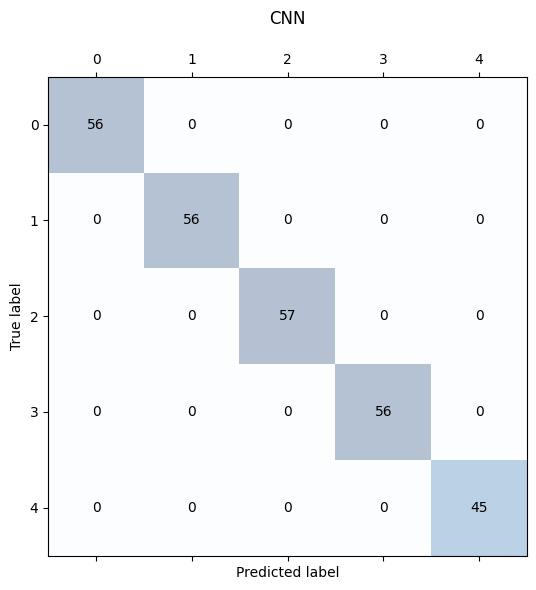

In [14]:
# Confusion matrix of testing data

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [15]:
# Calculating the precision, recall and f1 score

from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

Precision:  1.0
Recall:  1.0
F1-score:  1.0


## Save the final Fine-Tuned model

In [16]:
# Saves the best model obtained
model3_FT.save("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/Model3_FT.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
